Info in <TCanvas::Print>: png file s12_vertical.png has been created
Info in <TCanvas::Print>: png file s18_vertical.png has been created
Info in <TCanvas::Print>: png file s12_radial.png has been created
Info in <TCanvas::Print>: png file s18_radial.png has been created


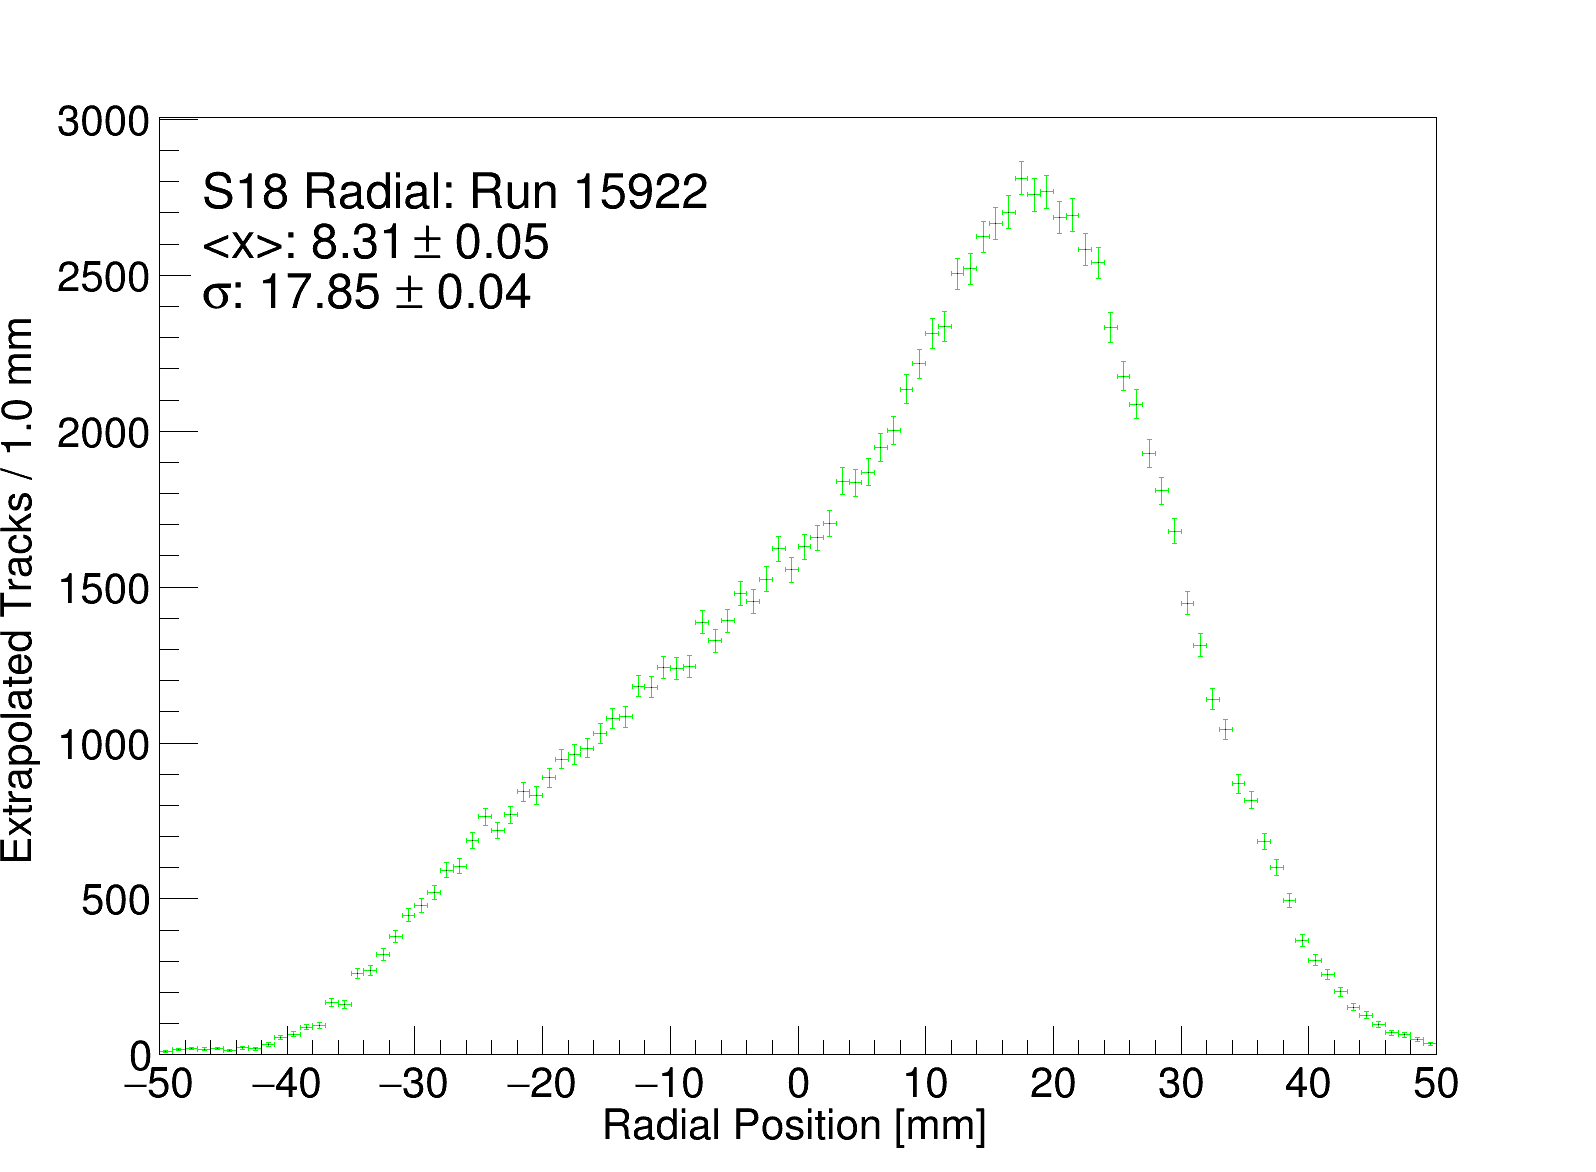

In [36]:
# Jupyter ROOT import 
import sys
sys.path.append("/usr/local/Cellar/root/6.16.00_3/lib/root")
# ROOT includes 
from ROOT import TH1D, TH2D, TF1, TCanvas, TFile, gStyle, TLegend, gROOT

#Define constant paths and labels 
station12Path = "Extrapolation/vertices/station12/"
station18Path = "Extrapolation/vertices/station18/"
scr_nominal = "/Users/gleb/software/alignTrack/mpIIDESY/BK/15922/trackRecoPlots_15922_Iter1.root"
stateN = 1 # nominal (0)

#Final plots and canvases names (looped over i_plot)
canvasName = ["s12_vertical", "s18_vertical", "s12_radial", "s18_radial"]
canvasTitle = ["S12 Vertical", "S18 Vertical", "S12 Radial", "S18 Radial"]
plotPath = [station12Path, station18Path, station12Path, station18Path]
plotName=["h_verticalPos_vs_time", "h_verticalPos_vs_time", "h_radialPos_vs_time", "h_radialPos_vs_time"] # TFile TH2 names  

#Legen labels (looped over i_state)
legendName = ["Iteration1"]
colorLine = [3] #  green
colorHisto = [3] # green

#Open TFiles (looped over i_state)
scrFile_nominal = TFile.Open(scr_nominal)
fileName = [scrFile_nominal,] # nominal (0) 

#Global empty containers to be filled for vertical or radial (in the main loop)
result = "-1"
mean = -1
mean_error = -1 
sd = -1 
sd_error = -1 

###### Plotting ##########

for i_plot in range(0, len(canvasName)):

    #Make new canvas for plots (4 in total)
    canvas = TCanvas(str(canvasName[i_plot]), " ", 1600, 1200)
    
    #Postion legend once per main loop accordingly 
    legend =  TLegend(0.12, 0.7, 0.4, 0.89)   
           
    #Loop over the 2 iterations (nominal and shift)
    for i_state in range(0, stateN):
    
        #Get the TH2F 
        histo_2D = fileName[i_state].Get(str(plotPath[i_plot])+plotName[i_plot])
        
        #Apply 30 us time cut 
        first_bin = histo_2D.GetXaxis().FindBin(30.0)
        
        tmpNameTH1 = "tmpNameTH1_"+str(i_state) # assign a new "name pointer" to the TH1 object for each loop 
        hist_1D = histo_2D.ProjectionY(tmpNameTH1, first_bin, -1)
        hist_1D.SetTitle("")
        hist_1D.GetXaxis().SetRangeUser(-50, 50) # applying a maximum range cut 
        binN=hist_1D.GetBinWidth(1)
        hist_1D.GetYaxis().SetTitle("Extrapolated Tracks / "+str(binN)+" mm")
        hist_1D.GetYaxis().CenterTitle()
        hist_1D.GetXaxis().CenterTitle()
        hist_1D.GetYaxis().SetTitleOffset(1.4);
        hist_1D.GetYaxis().SetTitleSize(0.039)
        hist_1D.GetYaxis().SetLabelSize(0.039)
        hist_1D.GetXaxis().SetTitleSize(0.039)
        hist_1D.GetXaxis().SetLabelSize(0.039)
            
        #Do a fit for vertical only 
        if( canvasName[i_plot] == "s12_vertical" or  canvasName[i_plot] == "s18_vertical"):
            
            #Define a Gaussian fit function between -30 to 30 mm 
            tmpNameTF1 = "tmpNameTF1_"+str(i_state)
            gF = TF1(tmpNameTF1, "gaus", -30.0, 30.0)
            
            #Draw on canvas 
            gF.SetLineColor(colorLine[i_state])
            hist_1D.SetLineColor(colorHisto[i_state])
            if (i_state == 0):
                hist_1D.Draw("E1")
                hist_1D.Fit(gF, "QR") # quite fit over the specified range above
                
            else:
                hist_1D.Draw("E1 same")
                hist_1D.Fit(gF, "QR same") # quite fit over the specified range above   
            
            #Get stats from fit 
            mean = round(gF.GetParameter(1), 2)
            mean_error = round(gF.GetParError(1), 2)
            sd = round(gF.GetParameter(2), 2)
            sd_error = round(gF.GetParError(2), 2)
            result = "<y>"
            legenObject = gF
            hist_1D.GetXaxis().SetTitle("Vertical Position [mm]")
           
        #Extract mean from a radial histogram only  
        if( canvasName[i_plot] == "s12_radial" or  canvasName[i_plot] == "s18_radial"):
            
            #Draw on canvas 
            hist_1D.SetLineColor(colorHisto[i_state])
            if (i_state == 0):
                hist_1D.Draw("E1")
                
            else:
                hist_1D.Draw("E1 same")
            
            #Get stats from hist 
            mean = round(hist_1D.GetMean(), 2)
            mean_error = round(hist_1D.GetMeanError(), 2)
            sd = round(hist_1D.GetRMS(), 2)
            sd_error = round(hist_1D.GetRMSError(), 2)
            result = "<x>"
            legenObject = hist_1D
            hist_1D.GetXaxis().SetTitle("Radial Position [mm]")
            
            
        #take care of the legend
        legenValue1 = str(result)+": "+str(mean)+" #pm "+str(mean_error) 
        legenValue2 = "#sigma: "+str(sd)+" #pm "+str(sd_error)
        legend.SetTextSize(.028)
        legend.Draw("same")
        
    
    #Do some final massagin and save to a file
    legend.SetHeader("#splitline{"+str(canvasTitle[i_plot])+": Run 15922}{#splitline{"+str(legenValue1)+"}{"+str(legenValue2)+"}}"); # option "C" allows to center the header
    gStyle.SetOptStat(0)
    gStyle.SetOptFit(0)
    legend.SetTextSize(.045)
    gStyle.SetLegendBorderSize(0)
    canvas.Draw()
    canvas.Print(str(canvasName[i_plot])+".png")